# fast.ai Experiments to predict Grit Mindset

## Import Libraries

In [1]:
from fastai.tabular import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score

### Note Notebook doesn't display all the rows and columns
- let's fix that

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Check CSV file inside data folder

In [3]:
! ls data

GritMindset.csv                      models
GritMindset.csvDroppedNaNCols.pickle


In [4]:
def loadData(csvFile):
    pickleDump = '{}DroppedNaNCols.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False)
        # clean data
        # strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col] == 'Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
            
        # drop all columns with NaN values
        beforeColumns = df.shape[1]
        df.dropna(axis='columns', inplace=True)
        print('Dropped {} columns with NaN values'.format(beforeColumns - df.shape[1]))
        # drop all rows with NaN values
        beforeRows = df.shape[0]
        df.dropna(inplace=True)
        print('Dropped {} rows with NaN values'.format(beforeRows - df.shape[0]))
        df.to_pickle(pickleDump)
        
    return df

In [5]:
df = loadData('data/GritMindset.csv')

In [6]:
# let's check the shape again
df.shape

(309, 4)

In [7]:
# display first 5 samples
df.head()

,Gender,Age,HighSchoolGrade,HonorsScience
0,1,19,85.0,2
1,2,19,94.0,1
2,1,19,85.0,2
3,2,19,80.0,2
4,2,18,78.0,2


In [8]:
df.columns

Index(['Gender', 'Age', 'HighSchoolGrade', 'HonorsScience'], dtype='object')

In [9]:
# class distribution
label = 'HonorsScience'
print(df.groupby(label).size())

HonorsScience
1     48
2    261
dtype: int64


## Binary-class classification
- Relabel HonorsScience 1 as 0 and 2 as 1

In [10]:
lblTypes = set(df[label])
lblTypes

{1, 2}

In [11]:
lblTypes = dict(zip(lblTypes, [0]*2))
lblTypes[2] = 1
lblTypes

{1: 0, 2: 1}

In [12]:
df[label] = df[label].map(lblTypes)

In [13]:
df.head()

,Gender,Age,HighSchoolGrade,HonorsScience
0,1,19,85.0,1
1,2,19,94.0,0
2,1,19,85.0,1
3,2,19,80.0,1
4,2,18,78.0,1


In [14]:
procs = [FillMissing, Categorify, Normalize]
sss = StratifiedShuffleSplit(n_splits = 10, test_size=0.2, random_state=0)
print(sss)

StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.2,
            train_size=None)


In [19]:
dep_var = label
dataPath = 'data'
cat_names = ['Gender']
cont_names = ['Age', 'HighSchoolGrade']
loss = 0
acc = []
for train_idx, test_idx in sss.split(df.index, df[dep_var]):
    data_fold = (TabularList.from_df(df, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[200, 100], metrics=[accuracy], callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=100)
    l, a = model.validate()
    loss += l
    acc.append(a)

In [20]:
# 10-fold cross validation average accuracy
print('loss {}: accuracy: {:.2f}% SD: {:.2f}%'.format(loss/10, np.mean(acc)*100, np.std(acc)*100))

loss 0.38870078772306443: accuracy: 88.06% SD: 4.34%


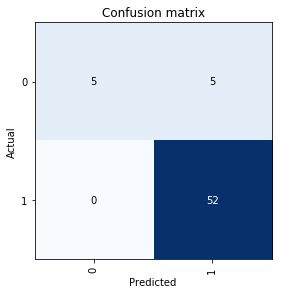

In [18]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)
interp.plot_confusion_matrix(slice_size=10)